In [56]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import math
import time

from scipy.stats import skew, kurtosis
from scipy.fft import fft2
from scipy import fftpack

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold,StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix



In [57]:
# data loading and feature extraction functions
def path_df(path):
    labels = []
    paths = []

# Iterate through each folder in the dataset directory
    for folder in os.listdir(dataset_dir):
        folder_path = os.path.join(dataset_dir, folder)
    # Check if the current item is a directory
        if os.path.isdir(folder_path):
        # Iterate through each image in the folder
            for image in os.listdir(folder_path):
            # Check if the current item is a PNG file
                if folder in ['16QAM_OSNR_25dB_ChSp_50GHz_TxPower_1dBm_NoJammingSignal', '16QAM_OSNR_25dB_ChSp_50GHz_TxPower_1dBm_PwrDiff_0dB_Gap_50GHz']:
                    labels.append(1)  # Normal
                else:
                    labels.append(-1)  # Anomalous
                # Append the image path to the list
                image_path = os.path.join(folder_path, image)
                paths.append(image_path)

# Create a dataframe from the image names, labels, and paths
    df = pd.DataFrame({'Path': paths, 'Label': labels})
    df = df.sort_values("Label", ascending=False)
    return df

def read_images_from_dataframe(dataframe, path_column):
    image_list = []
    for image_path in dataframe[path_column]:
        image = cv2.imread(image_path)
        image_list.append(image)
    return image_list




def compute_fourier_coefficients(image):
    if image.shape[2]== 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # Convert image to grayscale
    else:
        gray_image = image
        
    f = np.fft.fft2(gray_image)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20 * np.log(np.abs(fshift))

    return magnitude_spectrum

def compute_fourier_features(image, axis = 0):
    if image.shape[2]== 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # Convert image to grayscale
    else:
        gray_image = image

    f = np.fft.fft2(gray_image)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20 * np.log(np.abs(fshift))
# Compute the power spectrum
    epsilon = 1e-8
    power_spectrum = np.abs(fshift) ** 2 +epsilon
# Normalize the power spectrum (optional)
    normalized_spectrum = np.log10(power_spectrum + 1)
    # Compute additional Fourier features
    column_wise_mean = np.mean(magnitude_spectrum, axis=axis)
    column_wise_variance = np.var(magnitude_spectrum, axis=axis)
    column_wise_skew = skew(magnitude_spectrum, axis=axis)
    column_wise_kurtosis = kurtosis(magnitude_spectrum, axis=axis)
    
    # Normalizing the features
    scaler = MinMaxScaler()
    normalized_mean = scaler.fit_transform(column_wise_mean.reshape(-1, 1)).flatten()
    normalized_variance = scaler.fit_transform(column_wise_variance.reshape(-1, 1)).flatten()
    normalized_skew = scaler.fit_transform(column_wise_skew.reshape(-1, 1)).flatten()
    normalized_kurtosis = scaler.fit_transform(column_wise_kurtosis.reshape(-1, 1)).flatten()

    # Concatenate the computed features into a single vector
    features = [normalized_mean, normalized_variance, normalized_skew, normalized_kurtosis]#, normalized_spectrum]

    return features

def compute_spatial_features(image, axis=0):
    if image.shape[2]== 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # Convert image to grayscale
    else:
        gray_image = image
    
    gray_image = np.array(gray_image)
     
    column_wise_mean = np.mean(gray_image, axis=axis)
    column_wise_variance = np.var(gray_image, axis=axis)
    column_wise_skew = skew(gray_image, axis=axis)
    column_wise_kurtosis = kurtosis(gray_image, axis=axis)
    
    scaler = MinMaxScaler()
    normalized_mean = scaler.fit_transform(column_wise_mean.reshape(-1, 1)).flatten()
    normalized_variance = scaler.fit_transform(column_wise_variance.reshape(-1, 1)).flatten()
    normalized_skew = scaler.fit_transform(column_wise_skew.reshape(-1, 1)).flatten()
    normalized_kurtosis = scaler.fit_transform(column_wise_kurtosis.reshape(-1, 1)).flatten()



    # Concatenate the computed features into a single vector
    features = [normalized_mean, normalized_variance, normalized_skew, normalized_kurtosis]

    return features
    

def compute_covariance_matrix(images, feature_domain, feature_type = "variance" ):
    feature_matrix = []
    if feature_domain == "spatial":
        for image in images:
            if feature_type == "mean":
                feature_matrix.append(compute_spatial_features(image)[0])
            elif feature_type == "variance":
                feature_matrix.append(compute_spatial_features(image)[1])
            elif feature_type == "skew":
                feature_matrix.append(compute_spatial_features(image)[2])
            elif feature_type == "kurtosis":
                feature_matrix.append(compute_spatial_features(image)[3])
    elif feature_domain == "fourier":
        for image in images:
            if feature_type == "mean":
                feature_matrix.append(compute_fourier_features(image)[0])
            elif feature_type == "variance":
                feature_matrix.append(compute_fourier_features(image)[1])
            elif feature_type == "skew":
                feature_matrix.append(compute_fourier_features(image)[2])
            elif feature_type == "kurtosis":
                feature_matrix.append(compute_fourier_features(image)[3])
                
    feature_matrix = np.array(feature_matrix)
    covariance_matrix = cov_mat_mean_spatial = np.cov(feature_matrix.T, rowvar=False)
    
    return covariance_matrix
        
    

In [58]:
# Plotting Functions 

def plot_features(images, labels, feature_domain):
    if feature_domain == "spatial":
        fig, axes = plt.subplots(len(images), 5, figsize=(15, 10))
        plt.subplots_adjust(wspace=0.5, hspace=0.5)
        
        for i, img in enumerate(images):
            ax = axes[i]
            ax[0].imshow(img)
            ax[0].set_title(labels[i])
            
            features = compute_spatial_features(img)
            ax[1].plot(features[0])
            ax[1].set_title("Mean")
            ax[2].plot(features[1])
            ax[2].set_title("Var")
            ax[3].plot(features[2])
            ax[3].set_title("Skew")
            ax[4].plot(features[3])
            ax[4].set_title("Kurtosis")
            
    elif feature_domain == "fourier":
        fig, axes = plt.subplots(len(images), 6, figsize=(20, 10))
        plt.subplots_adjust(wspace=0.5, hspace=0.5)
        
        for i, img in enumerate(images):
            ax = axes[i]
            ax[0].imshow(img)
            ax[0].set_title(labels[i])
            
            img_fft = compute_fourier_coefficients(img)
            ax[1].imshow(img_fft, cmap="gray")
            ax[1].set_title(f"{labels[i]} Fourier")
            
            features = compute_fourier_features(img)
            ax[2].plot(features[0])
            ax[2].set_title("Mean")
            ax[3].plot(features[1])
            ax[3].set_title("Var")
            ax[4].plot(features[2])
            ax[4].set_title("Skew")
            ax[5].plot(features[3])
            ax[5].set_title("Kurtosis")
            
    else:
        print("Invalid feature domain. Please choose either 'spatial' or 'fourier'.")
        


def plot_covariance_matrix(images, titles, image_labels, feature_domain):
    
    feature_list=[]
    if feature_domain == "spatial":
        for img in images:
            feature_list.append(compute_spatial_features(img))
    elif feature_domain == "fourier":
        for img in images:
            
            feature_list.append(compute_fourier_features(img))
            
    num_images = len(feature_list)
    num_features = len(feature_list[0])
    covariance_matrices = []
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
    plt.subplots_adjust(hspace=0.6, wspace=0.2)

    # Compute the covariance matrix for each feature
    for feature_index in range(num_features):
        # Initialize an empty covariance matrix for the current feature
        covariance_matrix = np.zeros((num_images, num_images))

        # Compute the pairwise covariance between the feature vectors of different images
        for i in range(num_images):
            for j in range(num_images):
                feature_vector_i = feature_list[i][feature_index]
                feature_vector_j = feature_list[j][feature_index]
                covariance_matrix[i, j] = np.cov(feature_vector_i, feature_vector_j, rowvar=False)[0, 1]

                # Annotate each matrix block with covariance value
                axes[feature_index // 2, feature_index % 2].text(
                    j, i, f'{covariance_matrix[i, j]:.3f}', ha='center', va='center', color="gray")

        # Label row and column indices based on their values
        row_labels = [image_labels[i] for i in range(num_images)]
        col_labels = [image_labels[j] for j in range(num_images)]

        # Annotate each row and column with labels
        for i in range(num_images):
            axes[feature_index // 2, feature_index % 2].text(
                -0.7, i, f'{row_labels[i]}\n{i}', ha='right', va='center', color='gray', rotation=-30)
            axes[feature_index // 2, feature_index % 2].text(
                i, num_images - 0.05, f'{col_labels[i]}\n{i}', ha='center', va='top', color='gray', rotation=65)

        # Plot the covariance matrix
        im = axes[feature_index // 2, feature_index % 2].imshow(
            covariance_matrix, cmap='hot', interpolation='nearest')
        axes[feature_index // 2, feature_index % 2].set_title(f'{titles[feature_index]}')

        covariance_matrices.append(covariance_matrix)

    # Add colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)

    plt.show()
    return covariance_matrices, plt.show()


import numpy as np
import matplotlib.pyplot as plt

def plot_covariance_histograms(covariance_matrices, titles):
    fig, axes = plt.subplots(nrows=1, ncols=len(covariance_matrices), figsize=(15, 4))
    plt.subplots_adjust(wspace=0.5)

    for feature_index, ax in enumerate(axes):
        # Get the covariance matrix
        cov_flat = covariance_matrices[feature_index].flatten()

        normal_cov = [cov_flat[0], cov_flat[1], cov_flat[5], cov_flat[6]]
        anomalous_cov = np.delete(cov_flat, [0, 1, 5, 6])

        # Plot the histograms
        ax.hist(anomalous_cov, bins=3, color='blue', alpha=0.5, label='Anomalous')
        ax.hist(normal_cov, bins=3, color='red', alpha=0.5, label='Normal')

        # Set labels and title for each subplot
        ax.set_xlabel('Covariance Value')
        ax.set_ylabel('Frequency')
        ax.set_title(f'Histogram of Covariance Values\n{titles[feature_index]}')

        # Add a legend to each subplot
        ax.legend()

    # Show the plot
    plt.show()



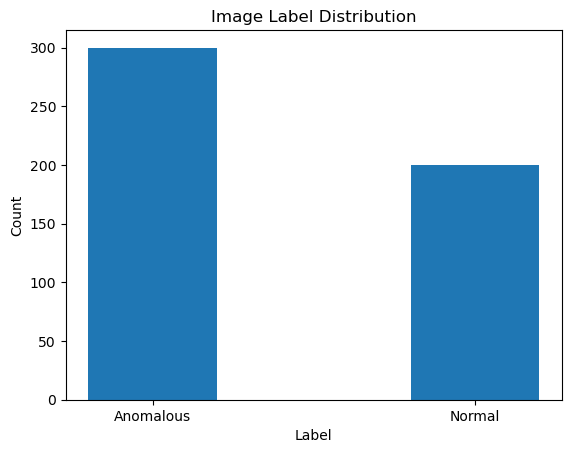

In [59]:
# Class Distributation

dataset_dir = '/kaggle/input/nda-dataset/Dataset'
df = path_df(dataset_dir)
# Plot the distribution of labels
label_counts = df['Label'].value_counts()

# Create a bar plot
plt.bar(label_counts.index, label_counts.values)

# Add labels and title
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Image Label Distribution')

# Add x-axis tick labels
plt.xticks(label_counts.index, ['Anomalous', 'Normal'])

# Display the plot
plt.show()



In [60]:
# choose 5 samples
img_norm1 = cv2.imread("/kaggle/input/nda-dataset/Dataset/16QAM_OSNR_25dB_ChSp_50GHz_TxPower_1dBm_NoJammingSignal/SimResults_16QAM_OSNR_25dB_ChSp_50GHz_TxPower_1dBm_NoJammingSignal.png")
img_norm2 = cv2.imread("/kaggle/input/nda-dataset/Dataset/16QAM_OSNR_25dB_ChSp_50GHz_TxPower_1dBm_PwrDiff_0dB_Gap_50GHz/SimResults_16QAM_OSNR_25dB_ChSp_50GHz_TxPower_1dBm_PwrDiff_0dB_Gap_50GHz.png")
img_fault1 = cv2.imread("/kaggle/input/nda-dataset/Dataset/16QAM_OSNR_25dB_ChSp_50GHz_TxPower_1dBm_PwrDiff_0dB_Gap_37.5GHz/SimResults_16QAM_OSNR_25dB_ChSp_50GHz_TxPower_1dBm_PwrDiff_0dB_Gap_37.5GHz.png")
img_fault2 = cv2.imread("/kaggle/input/nda-dataset/Dataset/16QAM_OSNR_25dB_ChSp_50GHz_TxPower_1dBm_PwrDiff_3dB_Gap_43.75GHz/SimResults_16QAM_OSNR_25dB_ChSp_50GHz_TxPower_1dBm_PwrDiff_3dB_Gap_43.75GHz.png")
img_fault3 = cv2.imread("/kaggle/input/nda-dataset/Dataset/16QAM_OSNR_25dB_ChSp_50GHz_TxPower_1dBm_PwrDiff_6dB_Gap_50GHz/SimResults_16QAM_OSNR_25dB_ChSp_50GHz_TxPower_1dBm_PwrDiff_6dB_Gap_50GHz.png")


In [61]:
image_samples = [img_norm1,img_norm2,img_fault1,img_fault2,img_fault3]
image_labels = ['Normal', 'Normal', 'Anomalous', 'Anomalous', 'Anomalous']

# Plotting Statistical Features

/tmp/ipykernel_32/1922560102.py:91: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  column_wise_skew = skew(gray_image, axis=axis)
/tmp/ipykernel_32/1922560102.py:92: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  column_wise_kurtosis = kurtosis(gray_image, axis=axis)
/tmp/ipykernel_32/1922560102.py:91: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  column_wise_skew = skew(gray_image, axis=axis)
/tmp/ipykernel_32/1922560102.py:92: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  column_wise_kur

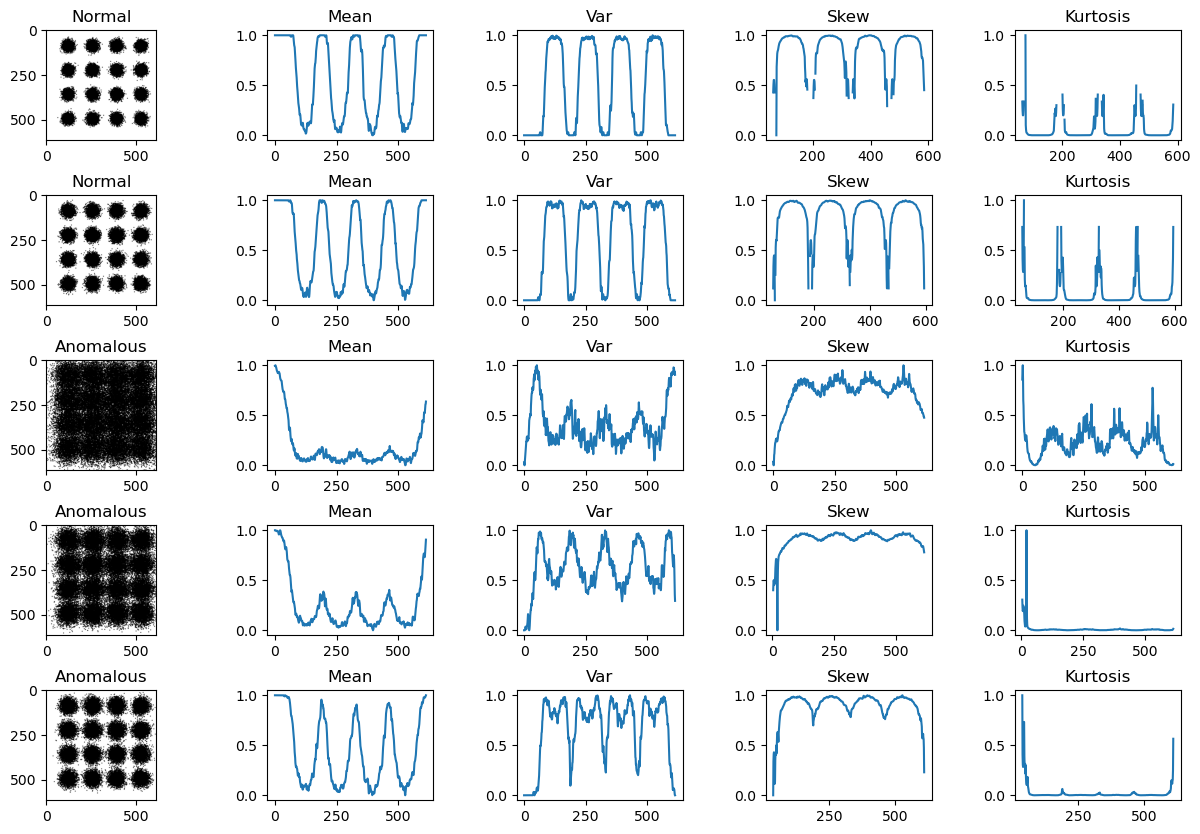

In [62]:
# spatial
plot_features(image_samples, image_labels, "spatial")

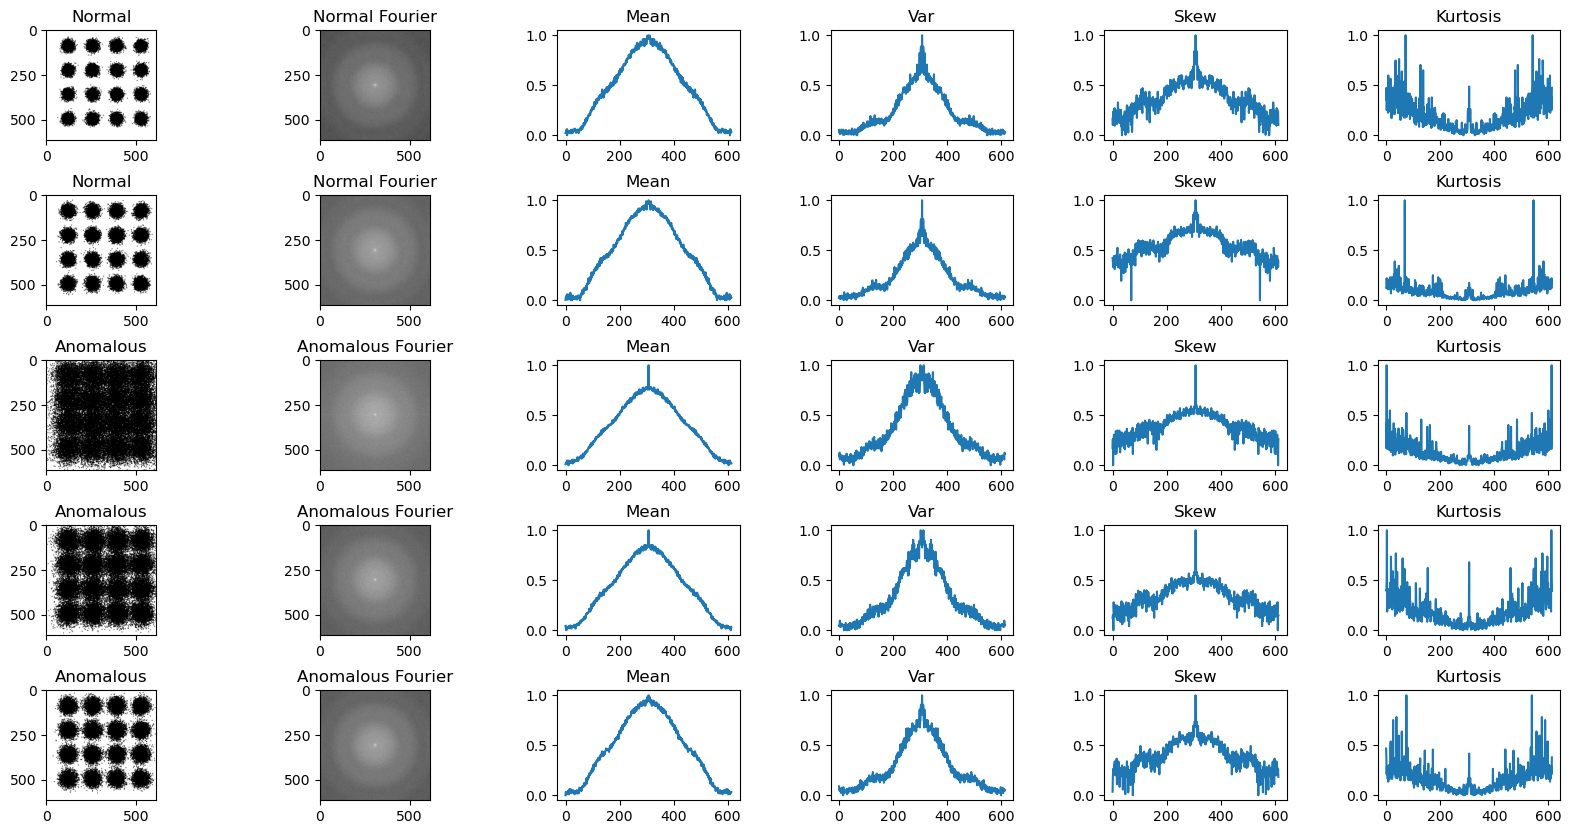

In [63]:
# fourier
plot_features(image_samples, image_labels, "fourier")

# Covariance Analysis

/tmp/ipykernel_32/1922560102.py:91: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  column_wise_skew = skew(gray_image, axis=axis)
/tmp/ipykernel_32/1922560102.py:92: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  column_wise_kurtosis = kurtosis(gray_image, axis=axis)
/tmp/ipykernel_32/1922560102.py:91: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  column_wise_skew = skew(gray_image, axis=axis)
/tmp/ipykernel_32/1922560102.py:92: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  column_wise_kur

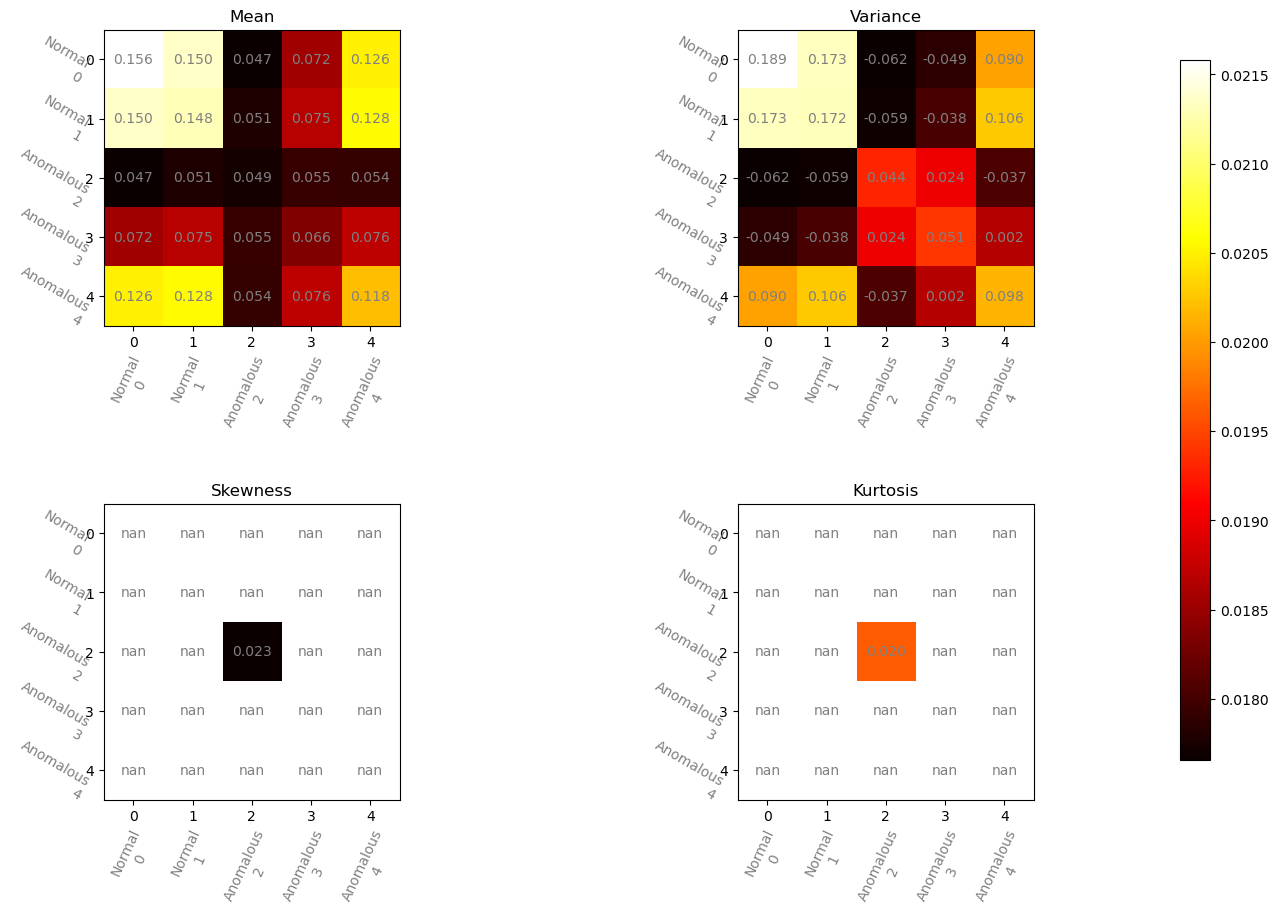

In [64]:
#spatial
titles = ['Mean', 'Variance', 'Skewness', 'Kurtosis']
cov_matrices_spatial, _ = plot_covariance_matrix(image_samples, titles, image_labels, "spatial")

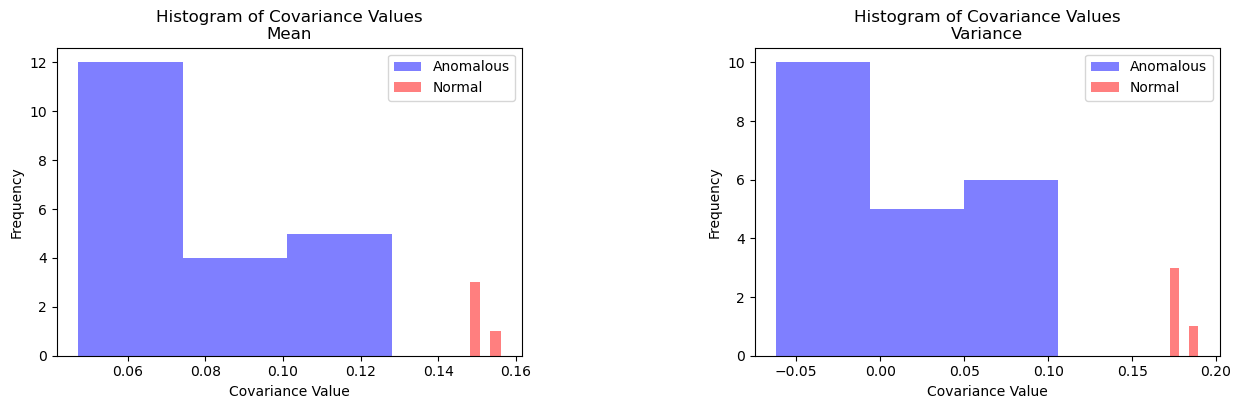

In [65]:
plot_covariance_histograms(cov_matrices_spatial[0:2], titles)

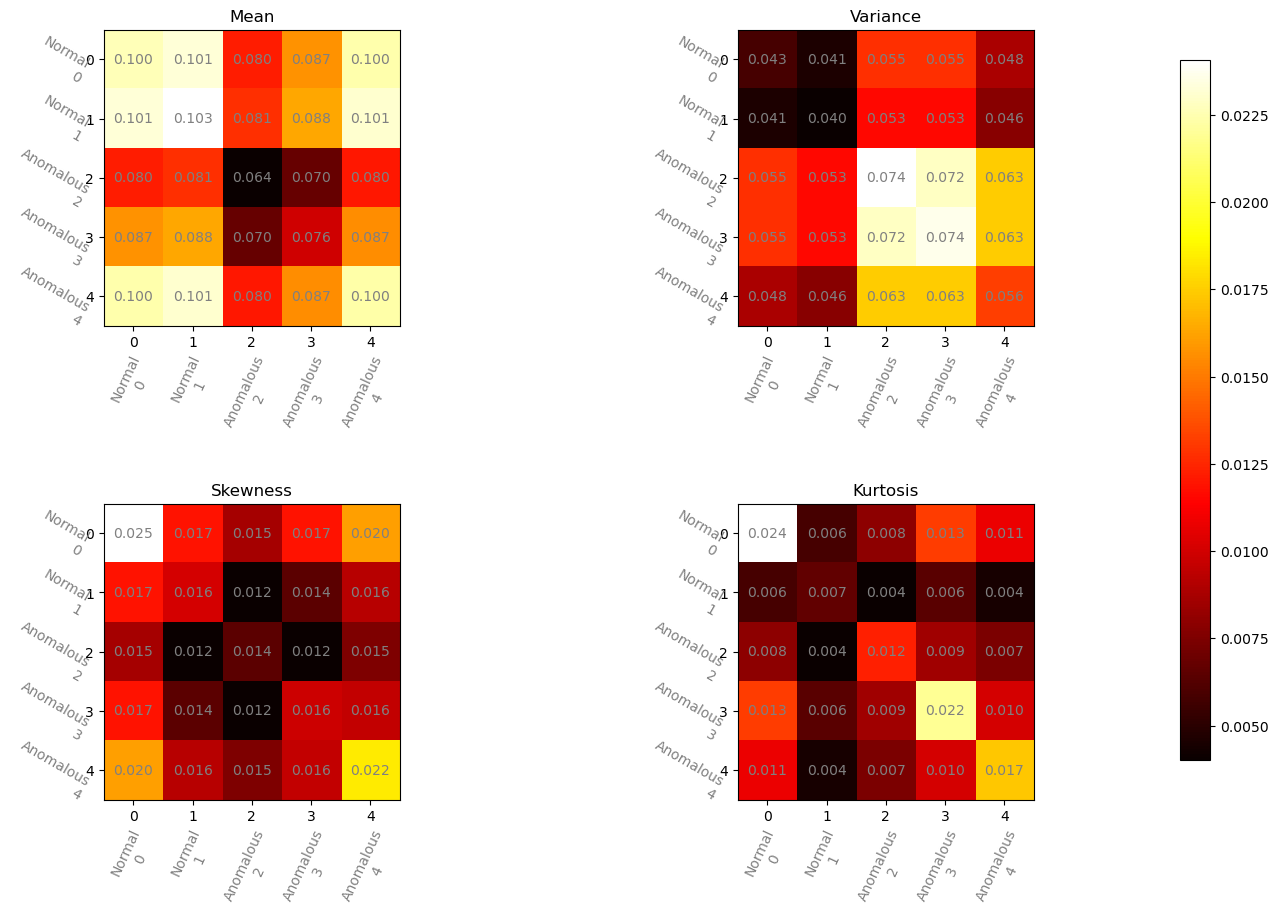

In [66]:
cov_matrices_fourier,_ = plot_covariance_matrix(image_samples, titles, image_labels, "fourier")

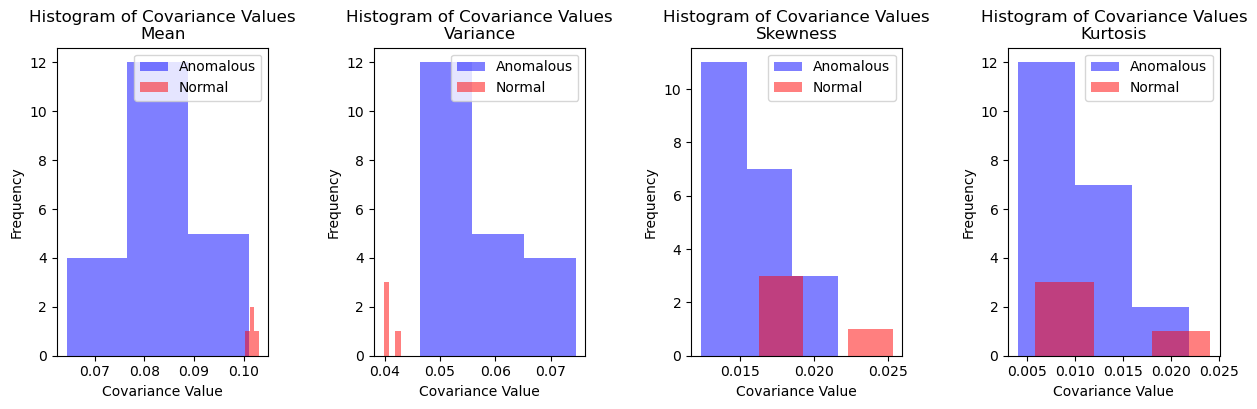

In [67]:
plot_covariance_histograms(cov_matrices_fourier, titles)

In [68]:
# Compute covariance matrix for all images
all_images = read_images_from_dataframe(df, "Path")
t0= time.time()
cov_mat_mean_spatial = compute_covariance_matrix(all_images, "spatial", "mean" )
t1=time.time()
cov_mat_var_spatial = compute_covariance_matrix(all_images, "spatial", "variance" )
cov_mat_var_fourier = compute_covariance_matrix(all_images, "fourier", "variance" )

/tmp/ipykernel_32/1922560102.py:91: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  column_wise_skew = skew(gray_image, axis=axis)
/tmp/ipykernel_32/1922560102.py:92: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  column_wise_kurtosis = kurtosis(gray_image, axis=axis)
/tmp/ipykernel_32/1922560102.py:91: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  column_wise_skew = skew(gray_image, axis=axis)
/tmp/ipykernel_32/1922560102.py:92: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  column_wise_kur

In [69]:
print("Duration of computing the Covariance matrix: ", str(t1-t0), " [s]")

Duration of computing the Covariance matrix:  8.054509162902832  [s]


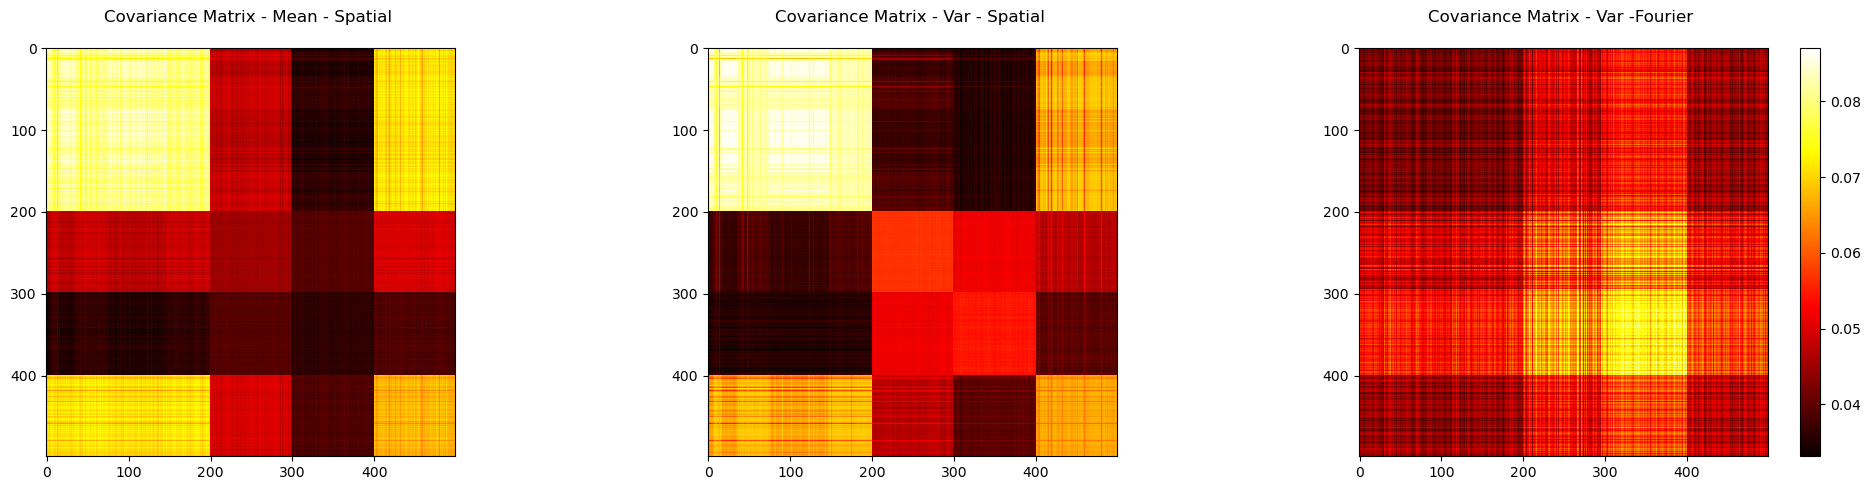

In [70]:
# Plotting covariance matrices
start = 0
end = -1

plt.figure(figsize=(20, 5))
#plt.subplots_adjust(hspace=0.6, wspace=0.2)

plt.subplot(1, 3, 1)  # 1 row, 3 columns, plot 1
plt.imshow(cov_mat_mean_spatial[start:end, start:end], cmap='hot', interpolation='nearest')
plt.title('Covariance Matrix - Mean - Spatial \n')


plt.subplot(1, 3, 2)  # 1 row, 3 columns, plot 2
plt.imshow(cov_mat_var_spatial[start:end, start:end], cmap='hot', interpolation='nearest')
plt.title('Covariance Matrix - Var - Spatial \n')


plt.subplot(1, 3, 3)  # 1 row, 3 columns, plot 3
plt.imshow(cov_mat_var_fourier[start:end, start:end], cmap='hot', interpolation='nearest')
plt.title('Covariance Matrix - Var -Fourier \n')

plt.colorbar()
# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()


In [71]:
cov_mat_mean_spatial.shape , cov_mat_var_spatial.shape , cov_mat_var_fourier.shape

((500, 500), (500, 500), (500, 500))

# PCA Analysis 

In [74]:
def pca_performer(data, n_components, feature_name="Feature"):
    pca = PCA(n_components= n_components)
    pca.fit(data)
    print("--------------------------------------\n")
    print('Variance represented by each component, %:')
    print(np.round(pca.explained_variance_ratio_, 3) * 100)
    
    
    fig=plt.figure()
    plt.bar(range(1,n_components+1), pca.explained_variance_ratio_ * 100)
    plt.xlabel('Number of components')
    plt.ylabel('Per-component explained variance (%)')
    plt.grid()
    plt.title(feature_name)
    fig.tight_layout()
   
    return pca.components_[:n_components].T , plt.show()

--------------------------------------

Variance represented by each component, %:
[99.  1.  0.  0.  0.  0.  0.  0.  0.  0.]


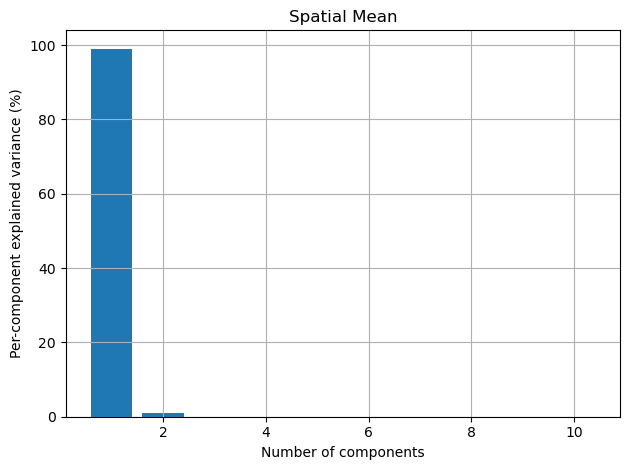

--------------------------------------

Variance represented by each component, %:
[97.9  2.1  0.1  0.   0.   0.   0.   0.   0.   0. ]


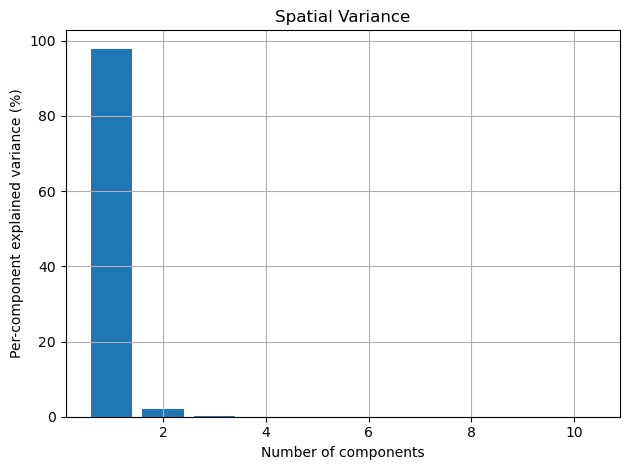

In [76]:
mean_spatial_pca,_ = pca_performer(cov_mat_mean_spatial, 10, "Spatial Mean")
var_spatial_pca,_ = pca_performer(cov_mat_var_spatial, 10, "Spatial Variance")

In [77]:
# choose first principle component
first_pc1 = mean_spatial_pca[:,0] #spatial Mean
first_pc2 = var_spatial_pca[:,0] #spatial Var
print("Shape of first principle componet of covariance of mean feature: ",first_pc1.shape)
print("Shape of first principle componet of covariance of variance feature:: ",first_pc2.shape)

Shape of first principle componet of covariance of mean feature:  (500,)
Shape of first principle componet of covariance of variance feature::  (500,)


# Training, Validation and Testing

In [78]:
# Data split function
def train_test_val_split(X_norm, X_fault, random_state =4321):
    
    labels_normal = np.ones(shape = X_norm.shape[0])
    labels_faulty = -1 * np.ones(shape = X_fault.shape[0])


    normal_train, normal_test, labels_normal_train, labels_normal_test = train_test_split(X_norm, labels_normal, test_size=0.2, random_state=random_state)
    X_train, y_train = normal_train, labels_normal_train
    if np.ndim(X_fault) != 1:
        X_test = np.vstack((normal_test, X_fault))
    else:
        X_test = np.concatenate((normal_test, X_fault))
    y_test = np.concatenate((labels_normal_test, labels_faulty))

    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, stratify=y_test, test_size=0.2, random_state=random_state)
    print('The number of records in the training dataset is', X_train.shape[0],'#-1:', np.where(y_train == -1)[0].shape[0],' #1:', np.where(y_train == 1)[0].shape[0]) 
    print('The number of records in the validation dataset is', X_val.shape[0],'#-1:', np.where(y_val == -1)[0].shape[0],' #1:', np.where(y_val == 1)[0].shape[0]) 
    print('The number of records in the testing dataset is', X_test.shape[0],'#-1:', np.where(y_test == -1)[0].shape[0],' #1:', np.where(y_test == 1)[0].shape[0])
    
    return X_train, X_val, X_test, y_train, y_val, y_test 

In [79]:
# Validation functions - hyper param tuning
def CV_one_class_svm(X_train, y_train, X_val, y_val, K):
    n_split_kfold = K
    skf = KFold(n_splits=n_split_kfold, shuffle=True, random_state=3)

    best_params = {'nu': 0, 'kernel': 0, 'gamma': 0, 'score': 0}
    nu_range = [0.01, 0.2, 0.7]
    kernel_range = ['rbf', 'sigmoid', 'linear']
    gamma_range = ['scale', 'auto']

    t0 = time.time() 
    
    best_stat = []
    accuracy_list = []  # New: List to store all accuracies
    
    for i, nu in enumerate(nu_range):  # loop over regularization parameter
        for j, kernel in enumerate(kernel_range):  # loop over maximum iterations
            for k, gamma in enumerate(gamma_range):
                print(f'Testing hyperparameters: nu: {nu}, kernel: {kernel}, gamma: {gamma}')
                stat = []
                for (train_index, val_index1), (_, val_index2) in zip(skf.split(X_train, y_train), skf.split(X_val, y_val)):
                    if np.ndim(X_val) != 1:
                        X_train_fold, X_test_fold = X_train[train_index], np.vstack((X_val[val_index2], X_train[val_index1]))
                    else:
                        X_train_fold, X_test_fold = X_train[train_index], np.concatenate((X_val[val_index2], X_train[val_index1]))
                    y_train_fold, y_test_fold = y_train[train_index], np.concatenate((y_val[val_index2], y_train[val_index1]))

                    one_class_svm = OneClassSVM(nu=nu, kernel=kernel, gamma=gamma)
                    one_class_svm.fit(X_train_fold)
                    pred = one_class_svm.predict(X_test_fold)
                    accuracy = sum(pred == y_test_fold) / y_test_fold.shape[0]
                    stat.append(accuracy)
                    accuracy_list.append(accuracy)  # New: Append accuracy to the list

                score = sum(stat) / n_split_kfold
                print('score', score)
                if score > best_params['score']:
                    best_params['score'] = score
                    best_params['nu'] = nu
                    best_params['kernel'] = kernel
                    best_params['gamma'] = gamma
                    best_stat = stat
                    #print('New best hyperparameters!!')
    t1 = time.time()
    crossval_time = round(t1 - t0, 3)
    print('Crossval time [s]: ' + str(crossval_time))
    print('Best hyperparams during crossval: ' + str(best_params))

    best_one_class_svm = OneClassSVM(nu=best_params['nu'], kernel=best_params['kernel'], gamma=best_params['gamma'])
    t0 = time.time()
    best_one_class_svm.fit(X_train, y_train)
    t1 = time.time()
    training_time = round(t1 - t0, 3)
    final_pred = best_one_class_svm.predict(X_val)
    finalscore = sum(final_pred == y_val) / y_val.shape[0]
    print('Accuracy of the final model on validation: ' + str(finalscore))
    print('Training time [s]: ' + str(training_time)) 

    cm = confusion_matrix(y_val, final_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    return best_one_class_svm, best_params, best_stat, accuracy_list  # Modified return statement




def CV_train_isolation_forest(X_train, y_train, X_val, y_val, K):
    n_split_kfold = K
    skf = KFold(n_splits=n_split_kfold, shuffle=True, random_state=3)

    best_params = {'n_estimators': 0, 'max_samples_range': 0, 'contamination': 0, 'score': 0}
    n_estimators_range = [50, 75, 100]
    max_samples_range = [10, 50, 100]
    contamination_range = [0.1, 0.3]

    t0 = time.time() 
    
    best_stat = stat
    for i, n_estimators in enumerate(n_estimators_range): 
        for j, max_samples in enumerate(max_samples_range): #loop over maximum iterations
            for k, contamination in enumerate(contamination_range):
                    print(f'Testing hyperparameters: n_estimators: {n_estimators}, max_samples: {max_samples}, contamination: {contamination}')
                    stats = []
                    for (train_index, val_index1), (_, val_index2) in zip(skf.split(X_train, y_train), skf.split(X_val, y_val)):
                        if np.ndim(X_train) != 1:
                            X_train_fold, X_test_fold = X_train[train_index], np.vstack((X_val[val_index2], X_train[val_index1]))
                        else:
                            X_train_fold, X_test_fold = X_train[train_index], np.concatenate((X_val[val_index2], X_train[val_index1]))
                        y_train_fold, y_test_fold = y_train[train_index], np.concatenate((y_val[val_index2], y_train[val_index1]))

                        isol_forest=IsolationForest(n_estimators=n_estimators, max_samples=max_samples, contamination=contamination)
                        isol_forest.fit(X_train_fold)
                        pred = isol_forest.predict(X_test_fold)
                        stats.append(sum(pred == y_test_fold)/y_test_fold.shape[0])

                    score = sum(stats) / n_split_kfold
                    print('score', score)
                    if score > best_params['score']:
                        best_params['score'] = score
                        best_params['n_estimators'] = n_estimators
                        best_params['max_samples'] = max_samples
                        best_params['contamination'] = contamination
                        best_stat = stat
    t1 = time.time()
    crossval_time = round(t1-t0,3)            
    print('Crossval time [s]: ' + str(crossval_time))
    print('Best hyperparams during crossval: ' + str(best_params))


    best_isol_forest=IsolationForest(n_estimators=best_params['n_estimators'], max_samples=best_params['max_samples'], 
                                contamination=best_params['contamination'])
    t0 = time.time()
    best_isol_forest.fit(X_train) 
    t1 = time.time()
    training_time = round(t1-t0,3)
    final_pred = best_isol_forest.predict(X_val)
    finalscore = sum(final_pred == y_val)/y_val.shape[0]
    print('Accuracy of the final model on validation: ' + str(finalscore))
    print('Training time [s]: ' + str(training_time)) 
    
    
    cm = confusion_matrix(y_val, final_pred)#, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)#,
                                  #display_labels=clf.classes_)
    disp.plot()
    plt.show()
    
    return best_isol_forest, best_params, best_stat

In [80]:
# Testing functions - evaluation
def evaluate_model(model, X_test, y_test):
    # test
    prediction = model.predict(X_test)

    print("Test Accuracy:", accuracy_score(y_test, prediction))
    print("Test classification report:")
    print(classification_report(y_test, prediction))


    cm = confusion_matrix(y_test, prediction)#, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)#, display_labels=clf.classes_)
    disp.plot()
    plt.show()

**Using covariance of mean feature**

In [81]:
X_norm = first_pc1[0:200]
X_fault = first_pc1[200:]

X_train, X_val, X_test, y_train, y_val, y_test  = train_test_val_split(X_norm, X_fault)

The number of records in the training dataset is 160 #-1: 0  #1: 160
The number of records in the validation dataset is 272 #-1: 240  #1: 32
The number of records in the testing dataset is 68 #-1: 60  #1: 8


Testing hyperparameters: nu: 0.01, kernel: rbf, gamma: scale
score 0.900427693130179
Testing hyperparameters: nu: 0.01, kernel: rbf, gamma: auto
score 0.8770649558941459
Testing hyperparameters: nu: 0.01, kernel: sigmoid, gamma: scale
score 0.5556535685645551
Testing hyperparameters: nu: 0.01, kernel: sigmoid, gamma: auto
score 0.9375300721732158
Testing hyperparameters: nu: 0.01, kernel: linear, gamma: scale
score 0.9375300721732158
Testing hyperparameters: nu: 0.01, kernel: linear, gamma: auto
score 0.9375300721732158
Testing hyperparameters: nu: 0.2, kernel: rbf, gamma: scale
score 0.9120823309275595
Testing hyperparameters: nu: 0.2, kernel: rbf, gamma: auto
score 0.6111734830259289
Testing hyperparameters: nu: 0.2, kernel: sigmoid, gamma: scale
score 0.5556535685645551
Testing hyperparameters: nu: 0.2, kernel: sigmoid, gamma: auto
score 0.9027800053461641
Testing hyperparameters: nu: 0.2, kernel: linear, gamma: scale
score 0.9027800053461641
Testing hyperparameters: nu: 0.2, kernel

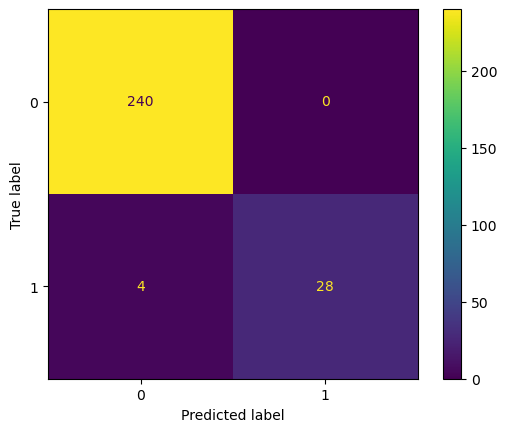

Average K-fold accuracy: 0.9375300721732158 +- 0.029807993430007708
Test Accuracy: 0.9852941176470589
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.98      1.00      0.99        60
         1.0       1.00      0.88      0.93         8

    accuracy                           0.99        68
   macro avg       0.99      0.94      0.96        68
weighted avg       0.99      0.99      0.98        68



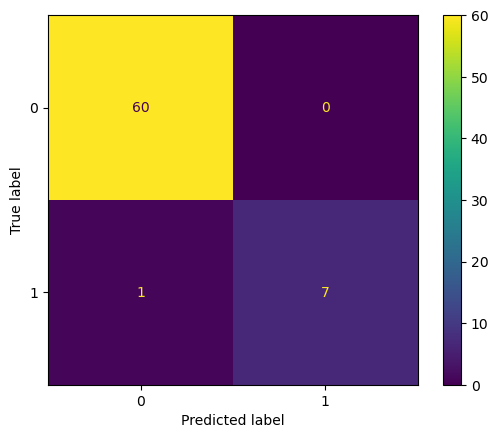

In [82]:
# OC_SVM
# val
one_class_svm_A, one_class_svm_params_A, stat, accuracy_list = CV_one_class_svm(X_train.reshape(-1, 1), y_train, X_val.reshape(-1, 1), y_val, 5)
print('Average K-fold accuracy:', np.mean(stat),'+-', np.std(stat))


evaluate_model(one_class_svm_A, X_test.reshape(-1, 1), y_test)

Testing hyperparameters: n_estimators: 50, max_samples: 10, contamination: 0.1
score 0.9513766372627639
Testing hyperparameters: n_estimators: 50, max_samples: 10, contamination: 0.3
score 0.863539160652232
Testing hyperparameters: n_estimators: 50, max_samples: 50, contamination: 0.1
score 0.9537289494787491
Testing hyperparameters: n_estimators: 50, max_samples: 50, contamination: 0.3
score 0.8518310612135792
Testing hyperparameters: n_estimators: 50, max_samples: 100, contamination: 0.1
score 0.9491045175086874
Testing hyperparameters: n_estimators: 50, max_samples: 100, contamination: 0.3
score 0.830954290296712
Testing hyperparameters: n_estimators: 75, max_samples: 10, contamination: 0.1
score 0.9537022186581128
Testing hyperparameters: n_estimators: 75, max_samples: 10, contamination: 0.3
score 0.8588612670408982
Testing hyperparameters: n_estimators: 75, max_samples: 50, contamination: 0.1
score 0.9514033680834002
Testing hyperparameters: n_estimators: 75, max_samples: 50, cont

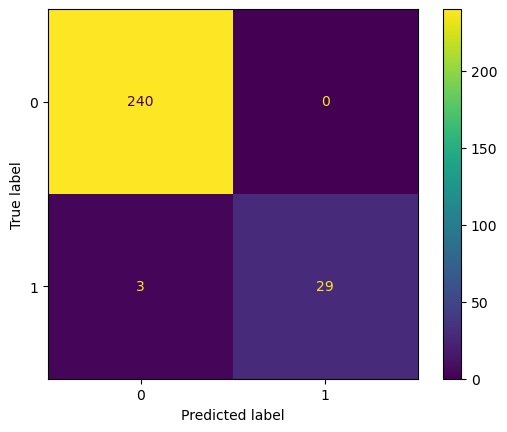

Average K-fold accuracy: 0.9375300721732158 +- 0.029807993430007708
Test Accuracy: 0.9852941176470589
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.98      1.00      0.99        60
         1.0       1.00      0.88      0.93         8

    accuracy                           0.99        68
   macro avg       0.99      0.94      0.96        68
weighted avg       0.99      0.99      0.98        68



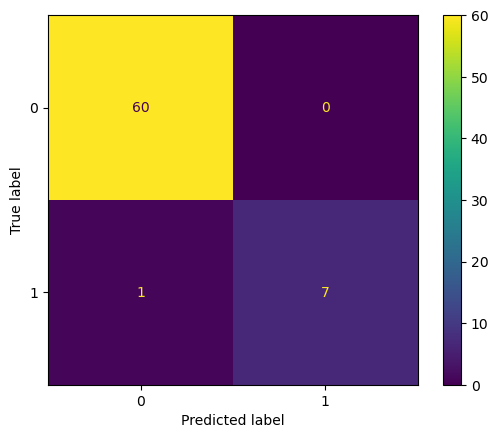

In [83]:
# IF
# val
isol_forest_A, isol_forest_params_A, stat = CV_train_isolation_forest(X_train.reshape(-1,1), y_train, X_val.reshape(-1,1), y_val, 5)
print('Average K-fold accuracy:', np.mean(stat),'+-', np.std(stat))

evaluate_model(isol_forest_A, X_test.reshape(-1,1), y_test)

**Using covariance of variance feature**

In [84]:
X_norm = first_pc2[0:200]
X_fault = first_pc2[200:]

X_train, X_val, X_test, y_train, y_val, y_test  = train_test_val_split(X_norm, X_fault)

The number of records in the training dataset is 160 #-1: 0  #1: 160
The number of records in the validation dataset is 272 #-1: 240  #1: 32
The number of records in the testing dataset is 68 #-1: 60  #1: 8


Testing hyperparameters: nu: 0.01, kernel: rbf, gamma: scale
score 0.9214113873295909
Testing hyperparameters: nu: 0.01, kernel: rbf, gamma: auto
score 0.8821438118150227
Testing hyperparameters: nu: 0.01, kernel: sigmoid, gamma: scale
score 0.5556535685645551
Testing hyperparameters: nu: 0.01, kernel: sigmoid, gamma: auto
score 0.8891205560010691
Testing hyperparameters: nu: 0.01, kernel: linear, gamma: scale
score 0.7226410050788559
Testing hyperparameters: nu: 0.01, kernel: linear, gamma: auto
score 0.7226410050788559
Testing hyperparameters: nu: 0.2, kernel: rbf, gamma: scale
score 0.9142742582197274
Testing hyperparameters: nu: 0.2, kernel: rbf, gamma: auto
score 0.6228548516439455
Testing hyperparameters: nu: 0.2, kernel: sigmoid, gamma: scale
score 0.5556535685645551
Testing hyperparameters: nu: 0.2, kernel: sigmoid, gamma: auto
score 0.9051857792034215
Testing hyperparameters: nu: 0.2, kernel: linear, gamma: scale
score 0.9051857792034215
Testing hyperparameters: nu: 0.2, kerne

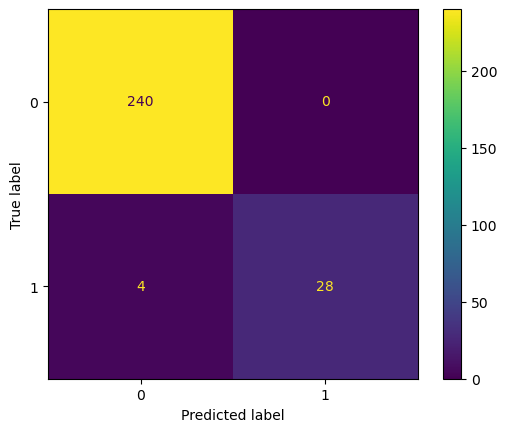

Average K-fold accuracy: 0.9214113873295909 +- 0.05048623422109497
Test Accuracy: 0.9705882352941176
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.97      1.00      0.98        60
         1.0       1.00      0.75      0.86         8

    accuracy                           0.97        68
   macro avg       0.98      0.88      0.92        68
weighted avg       0.97      0.97      0.97        68



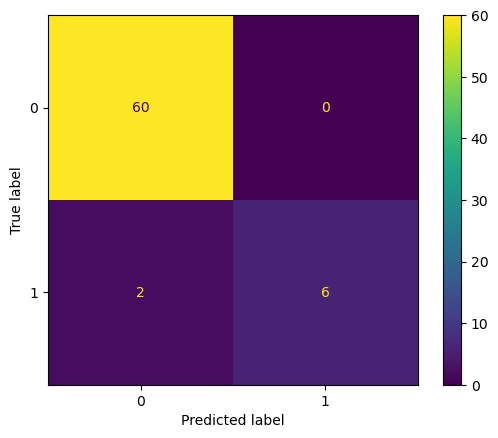

In [85]:
# OC_SVM
# val
one_class_svm_A, one_class_svm_params_A, stat, accuracy_list = CV_one_class_svm(X_train.reshape(-1, 1), y_train, X_val.reshape(-1, 1), y_val, 5)
print('Average K-fold accuracy:', np.mean(stat),'+-', np.std(stat))


evaluate_model(one_class_svm_A, X_test.reshape(-1, 1), y_test)

Testing hyperparameters: n_estimators: 50, max_samples: 10, contamination: 0.1
score 0.9560010692328256
Testing hyperparameters: n_estimators: 50, max_samples: 10, contamination: 0.3
score 0.8518577920342155
Testing hyperparameters: n_estimators: 50, max_samples: 50, contamination: 0.1
score 0.9490510558674151
Testing hyperparameters: n_estimators: 50, max_samples: 50, contamination: 0.3
score 0.8588612670408982
Testing hyperparameters: n_estimators: 50, max_samples: 100, contamination: 0.1
score 0.9467522052927025
Testing hyperparameters: n_estimators: 50, max_samples: 100, contamination: 0.3
score 0.8496124031007751
Testing hyperparameters: n_estimators: 75, max_samples: 10, contamination: 0.1
score 0.9537022186581128
Testing hyperparameters: n_estimators: 75, max_samples: 10, contamination: 0.3
score 0.87043571237637
Testing hyperparameters: n_estimators: 75, max_samples: 50, contamination: 0.1
score 0.9514033680834002
Testing hyperparameters: n_estimators: 75, max_samples: 50, cont

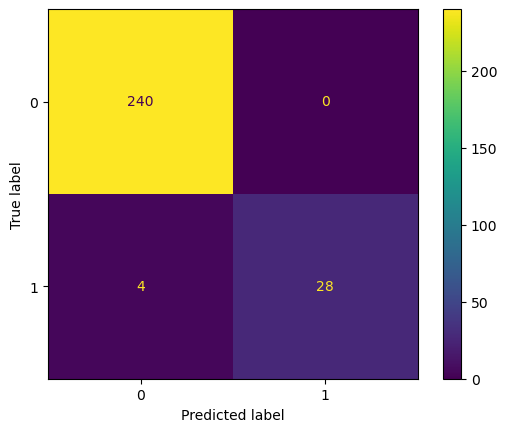

Average K-fold accuracy: 0.9214113873295909 +- 0.05048623422109497
Test Accuracy: 1.0
Test classification report:
              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00        60
         1.0       1.00      1.00      1.00         8

    accuracy                           1.00        68
   macro avg       1.00      1.00      1.00        68
weighted avg       1.00      1.00      1.00        68



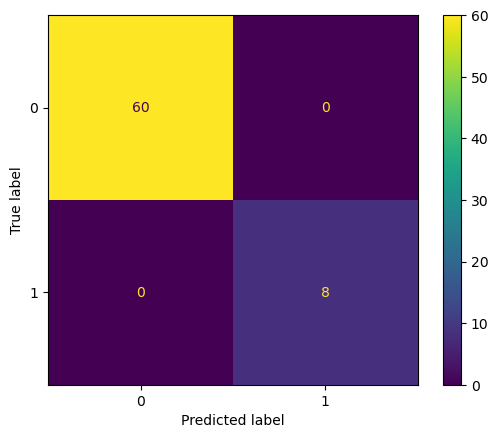

In [86]:
# IF
# val
isol_forest_A, isol_forest_params_A, stat = CV_train_isolation_forest(X_train.reshape(-1,1), y_train, X_val.reshape(-1,1), y_val, 5)
print('Average K-fold accuracy:', np.mean(stat),'+-', np.std(stat))

evaluate_model(isol_forest_A, X_test.reshape(-1,1), y_test)